#**REQUIRED DEPENDENCIES**

In [1]:
import torch
!pip install tools

In [2]:
import tools

In [3]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
model=torch.load('/content/gdrive/MyDrive/craft_mlt_25k.pth')

In [ ]:
print(model)

In [5]:
import typing

In [6]:
pip install git+https://github.com/qubvel/segmentation_models

  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-1jxkwzav
  Running command git clone -q https://github.com/qubvel/segmentation_models /tmp/pip-req-build-1jxkwzav
  Running command git submodule update --init --recursive -q
  Created wheel for segmentation-models: filename=segmentation_models-1.0.1-cp37-none-any.whl size=33794 sha256=a25a032d992000d5dab31702118b4a6e1efa34fe83cff1c60de05e50045abbaa
  Stored in directory: /tmp/pip-ephem-wheel-cache-8ohnebr1/wheels/49/cf/46/cbb4bb64518c402aea99df9d466f1081450597e653256bbcf4
Successfully built segmentation-models


#**IMAGE ANALYSIS**

In [7]:
import cv2
import numpy as np
import tensorflow as tf
import efficientnet.tfkeras as efficientnet
from tensorflow import keras

In [8]:
def compute_input(image):
    # should be RGB order
    image = image.astype('float32')
    mean = np.array([0.485, 0.456, 0.406])
    variance = np.array([0.229, 0.224, 0.225])

    image -= mean * 255
    image /= variance * 255
    return image

In [9]:
def invert_input(X):
    X = X.copy()
    mean = np.array([0.485, 0.456, 0.406])
    variance = np.array([0.229, 0.224, 0.225])

    X *= variance * 255
    X += mean * 255
    return X.clip(0, 255).astype('uint8')

In [10]:
def get_gaussian_heatmap(size=512, distanceRatio=3.34):
    v = np.abs(np.linspace(-size / 2, size / 2, num=size))
    x, y = np.meshgrid(v, v)
    g = np.sqrt(x**2 + y**2)
    g *= distanceRatio / (size / 2)
    g = np.exp(-(1 / 2) * (g**2))
    g *= 255
    return g.clip(0, 255).astype('uint8')

#**PRE PROCESSING DATA**

In [23]:
f = open('/content/gdrive/MyDrive/OCR_detection_annotation/0.txt', 'r')

In [24]:
file_contents = f.read()

In [25]:
print (file_contents)

15.025299 79.619064 91.971375 27.37761 111.49409 87.36937 120.44259 144.5673 और
195.26416 345.93964 346.07916 195.40369 296.7271 296.54498 411.9508 412.13293 किस
544.8015 579.83813 541.4978 506.46115 42.720642 60.455795 136.19897 118.46382 दिन
275.59427 311.88095 302.1434 265.85672 134.48518 159.5067 173.62825 148.60674 रूप
30.469978 163.88913 164.9093 31.490135 182.98358 181.51782 274.3758 275.84155 इस
33.57235 184.95844 185.26584 33.879738 354.1837 353.62552 436.9943 437.55246 तरह
-2.6164436 45.761616 53.37768 4.9996223 155.51007 137.70114 158.39023 176.19916 साथ
343.8163 512.32336 512.94495 344.4379 134.2903 132.54332 192.49599 194.24297 एकाएक
337.52948 504.81384 505.13098 337.84662 241.95956 240.91986 291.94846 292.98816 रमानाथ
507.9361 555.0499 523.0799 475.96606 4.7673645 56.682793 85.69593 33.780502 गया



In [26]:
print(file_contents[0:9])

15.025299


In [27]:
with open('/content/gdrive/MyDrive/OCR_detection_annotation/0.txt') as file_in:
    lines = []
   
    i=0
    for line in file_in:
        lines.append(line)
        i = i + 1
        print('Line No ='+str(i)+'\t '+line)

Line No =1	 15.025299 79.619064 91.971375 27.37761 111.49409 87.36937 120.44259 144.5673 और

Line No =2	 195.26416 345.93964 346.07916 195.40369 296.7271 296.54498 411.9508 412.13293 किस

Line No =3	 544.8015 579.83813 541.4978 506.46115 42.720642 60.455795 136.19897 118.46382 दिन

Line No =4	 275.59427 311.88095 302.1434 265.85672 134.48518 159.5067 173.62825 148.60674 रूप

Line No =5	 30.469978 163.88913 164.9093 31.490135 182.98358 181.51782 274.3758 275.84155 इस

Line No =6	 33.57235 184.95844 185.26584 33.879738 354.1837 353.62552 436.9943 437.55246 तरह

Line No =7	 -2.6164436 45.761616 53.37768 4.9996223 155.51007 137.70114 158.39023 176.19916 साथ

Line No =8	 343.8163 512.32336 512.94495 344.4379 134.2903 132.54332 192.49599 194.24297 एकाएक

Line No =9	 337.52948 504.81384 505.13098 337.84662 241.95956 240.91986 291.94846 292.98816 रमानाथ

Line No =10	 507.9361 555.0499 523.0799 475.96606 4.7673645 56.682793 85.69593 33.780502 गया



In [28]:
def create_2d_list(PATH):
  with open(PATH) as fi:
    lines_of_text = []
    for li in fi:
      lines_of_text.append(li.split(' '))

  coordinates = []
  words = []
  for i in lines_of_text:
    coordinates.append(i[:8])
    words.append(i[8:9])
  return coordinates,words


In [29]:
ordinates , ww = create_2d_list('/content/gdrive/MyDrive/OCR_detection_annotation/0.txt')

In [30]:
print(ordinates)

[['15.025299', '79.619064', '91.971375', '27.37761', '111.49409', '87.36937', '120.44259', '144.5673'], ['195.26416', '345.93964', '346.07916', '195.40369', '296.7271', '296.54498', '411.9508', '412.13293'], ['544.8015', '579.83813', '541.4978', '506.46115', '42.720642', '60.455795', '136.19897', '118.46382'], ['275.59427', '311.88095', '302.1434', '265.85672', '134.48518', '159.5067', '173.62825', '148.60674'], ['30.469978', '163.88913', '164.9093', '31.490135', '182.98358', '181.51782', '274.3758', '275.84155'], ['33.57235', '184.95844', '185.26584', '33.879738', '354.1837', '353.62552', '436.9943', '437.55246'], ['-2.6164436', '45.761616', '53.37768', '4.9996223', '155.51007', '137.70114', '158.39023', '176.19916'], ['343.8163', '512.32336', '512.94495', '344.4379', '134.2903', '132.54332', '192.49599', '194.24297'], ['337.52948', '504.81384', '505.13098', '337.84662', '241.95956', '240.91986', '291.94846', '292.98816'], ['507.9361', '555.0499', '523.0799', '475.96606', '4.7673645',

In [31]:
print(ww)

[['और\n'], ['किस\n'], ['दिन\n'], ['रूप\n'], ['इस\n'], ['तरह\n'], ['साथ\n'], ['एकाएक\n'], ['रमानाथ\n'], ['गया\n']]


In [32]:
ground_truth = []
for i in ww:
  for j in i:
    ground_truth.append(j.strip('\n'))

In [33]:
print(ground_truth)

['और', 'किस', 'दिन', 'रूप', 'इस', 'तरह', 'साथ', 'एकाएक', 'रमानाथ', 'गया']


In [34]:
import pandas as pd

In [35]:
df = pd.DataFrame({
    "Co-ordinates" : pd.Series(ordinates),
    "Ground_Truth" : pd.Series(ground_truth)
})

In [36]:
pd.set_option("display.max_columns",100)

In [37]:
df

,Co-ordinates,Ground_Truth
0,"[15.025299, 79.619064, 91.971375, 27.37761, 11...",और
1,"[195.26416, 345.93964, 346.07916, 195.40369, 2...",किस
2,"[544.8015, 579.83813, 541.4978, 506.46115, 42....",दिन
3,"[275.59427, 311.88095, 302.1434, 265.85672, 13...",रूप
4,"[30.469978, 163.88913, 164.9093, 31.490135, 18...",इस
5,"[33.57235, 184.95844, 185.26584, 33.879738, 35...",तरह
6,"[-2.6164436, 45.761616, 53.37768, 4.9996223, 1...",साथ
7,"[343.8163, 512.32336, 512.94495, 344.4379, 134...",एकाएक
8,"[337.52948, 504.81384, 505.13098, 337.84662, 2...",रमानाथ
9,"[507.9361, 555.0499, 523.0799, 475.96606, 4.76...",गया


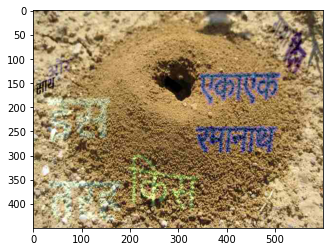

In [38]:
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt 
  
# Read Images 
img = mpimg.imread('/content/gdrive/MyDrive/OCR_detection/0.jpg') 
  
# Output Images 
plt.imshow(img) 

In [39]:
IMAGE = compute_input(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


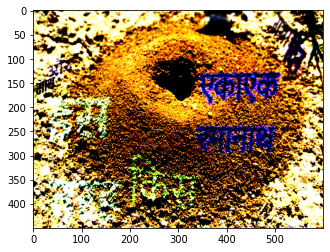

In [40]:
plt.imshow(IMAGE)

In [41]:
from PIL import Image

In [42]:
im = Image.open('/content/gdrive/MyDrive/OCR_detection/0.jpg')

In [43]:
im.save('/content/gdrive/MyDrive/OCR_detection/0_hq.jpg',quality = 100)

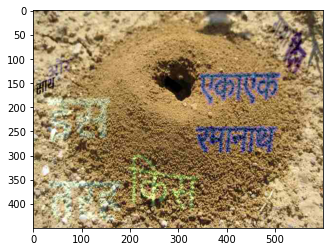

In [44]:
plt.imshow(im)

#**EAST MODEL**
[EAST Model Detection Research Paper MIT](chrome-extension://oemmndcbldboiebfnladdacbdfmadadm/https://arxiv.org/pdf/1704.03155v2.pdf)

In [11]:
print(tf.version.VERSION)

2.4.1


In [12]:
import tensorflow as tf
import numpy as np

RESIZE_FACTOR = 2

In [13]:
def resize_bilinear(x):
  return tf.compat.v1.image.resize_bilinear(x, size=[tf.shape(x)[1] * RESIZE_FACTOR, tf.shape(x)[2] * RESIZE_FACTOR])

In [14]:
def resize_output_shape(input_shape):
  shape = list(input_shape)
  assert len(shape) == 4
  shape[1] *= RESIZE_FACTOR
  shape[2] *= RESIZE_FACTOR
  return tuple(shape)

In [17]:
class EAST_model(tf.keras.Model):
  def __init__(self, input_size=512):
    super(EAST_model, self).__init__()

    input_image = tf.keras.layers.Input(shape=(None, None, 3), name='input_image')
    overly_small_text_region_training_mask = tf.keras.layers.Input(shape=(None, None, 1), name='overly_small_text_region_training_mask')
    text_region_boundary_training_mask = tf.keras.layers.Input(shape=(None, None, 1), name='text_region_boundary_training_mask')
    target_score_map = tf.keras.layers.Input(shape=(None, None, 1), name='target_score_map')
    resnet = tf.keras.applications.ResNet50(input_tensor=input_image, weights='imagenet', include_top=False, pooling=None)
    x = resnet.get_layer('conv5_block3_out').output

    x = tf.keras.layers.Lambda(resize_bilinear, name='resize_1')(x)
    x = tf.keras.layers.concatenate([x, resnet.get_layer('conv4_block6_out').output], axis=3)
    x = tf.keras.layers.Conv2D(128, (1, 1), padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-5))(x)
    x = tf.keras.layers.BatchNormalization(momentum=0.997, epsilon=1e-5, scale=True)(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(128, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-5))(x)
    x = tf.keras.layers.BatchNormalization(momentum=0.997, epsilon=1e-5, scale=True)(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Lambda(resize_bilinear, name='resize_2')(x)
    x = tf.keras.layers.concatenate([x, resnet.get_layer('conv3_block4_out').output], axis=3)
    x = tf.keras.layers.Conv2D(64, (1, 1), padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-5))(x)
    x = tf.keras.layers.BatchNormalization(momentum=0.997, epsilon=1e-5, scale=True)(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-5))(x)
    x = tf.keras.layers.BatchNormalization(momentum=0.997, epsilon=1e-5, scale=True)(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Lambda(resize_bilinear, name='resize_3')(x)
    x = tf.keras.layers.concatenate([x, resnet.get_layer('conv2_block3_out').output], axis=3)
    x = tf.keras.layers.Conv2D(32, (1, 1), padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-5))(x)
    x = tf.keras.layers.BatchNormalization(momentum=0.997, epsilon=1e-5, scale=True)(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(32, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-5))(x)
    x = tf.keras.layers.BatchNormalization(momentum=0.997, epsilon=1e-5, scale=True)(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(32, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-5))(x)
    x = tf.keras.layers.BatchNormalization(momentum=0.997, epsilon=1e-5, scale=True)(x)
    x = tf.keras.layers.Activation('relu')(x)

    pred_score_map = tf.keras.layers.Conv2D(1, (1, 1), activation=tf.nn.sigmoid, name='pred_score_map')(x)
    rbox_geo_map = tf.keras.layers.Conv2D(4, (1, 1), activation=tf.nn.sigmoid, name='rbox_geo_map')(x)
    rbox_geo_map = tf.keras.layers.Lambda(lambda x: x * input_size)(rbox_geo_map)
    angle_map = tf.keras.layers.Conv2D(1, (1, 1), activation=tf.nn.sigmoid, name='rbox_angle_map')(x)
    angle_map = tf.keras.layers.Lambda(lambda x: (x - 0.5) * np.pi / 2)(angle_map)
    pred_geo_map = tf.keras.layers.concatenate([rbox_geo_map, angle_map], axis=3, name='pred_geo_map')

    model = tf.keras.models.Model(inputs=[input_image], outputs=[pred_score_map, pred_geo_map])

    self.model = model
    self.input_image = input_image
    self.overly_small_text_region_training_mask = overly_small_text_region_training_mask
    self.text_region_boundary_training_mask = text_region_boundary_training_mask
    self.target_score_map = target_score_map
    self.pred_score_map = pred_score_map
    self.pred_geo_map = pred_geo_map
  
  def call(self, x):
    return self.model(x)

In [49]:
#LOSS FUNCTION used is called Dice-loss function

def dice_loss(overly_small_text_region_training_mask, text_region_boundary_training_mask, loss_weight, small_text_weight, score_y_true, score_y_pred):
  eps = 1e-5
  _training_mask = tf.minimum(overly_small_text_region_training_mask + small_text_weight, 1) * text_region_boundary_training_mask
  intersection = tf.reduce_sum(score_y_true * score_y_pred * _training_mask)
  union = tf.reduce_sum(score_y_true * _training_mask) + tf.reduce_sum(score_y_pred * _training_mask) + eps
  loss = 1. - (2. * intersection / union)

  return loss * loss_weight

In [18]:
Model = EAST_model()

94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
from PIL import Image 
from numpy import asarray 
  
img = Image.open('/content/gdrive/MyDrive/OCR_detection/0_hq.jpg') 
numpydata = asarray(img) 
  
print(type(numpydata)) 

print(numpydata.shape) 

In [ ]:
a = np.array(ordinates)
print(a)

In [62]:
def create_model():
  model = tf.keras.models.Sequential([
    keras.layers.Dense(512, activation='relu', input_shape=(784,)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(10)
  ])

  return model

In [63]:
MM = create_model()
MM.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


In [65]:
9

9